# Plot cumulative precipitation

Minimalistic example: extract total precipitation data from a netcdf dataset, plot accumulation as a function of time.

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
import xarray as xr
from datetime import datetime

In [36]:
def find_field(dataset, field_long_name):
    for v in dataset:
        if dataset[v].attrs['long_name'] == field_long_name:
            return dataset[v]
    raise ValueError('cannot find {}'.format(field_long_name))

def to_datetime(t):
    ns = 1e-9  # nanosecs in a sec
    FMT = '%Y-%m-%d_%H:%M:%S'
    return datetime.utcfromtimestamp(t.values.astype(int) * ns).strftime(FMT)

In [37]:
fname = './moloch_2018110302_AAABBBBCCC3001-lonlat.nc'

In [38]:
dataset = xr.open_dataset(fname)

In [39]:
times = dataset.coords['time']
lons = dataset.coords['lon']
lats = dataset.coords['lat']

In [40]:
from math import pi
radius = 6371 * 1000 # radius earth [m]
theta = pi/180 * lats.values
phi = pi/180 * lons.values
stheta = np.sin(theta)
dstheta = stheta[1:] - stheta[:-1]
dphi = phi[1:] - phi[:-1]
areas = radius**2 * np.outer(dstheta, dphi)

In [41]:
tpec = find_field(dataset, 'Total Precipitation')

In [42]:
tpec.attrs

OrderedDict([('long_name', 'Total Precipitation'),
             ('units', 'kg/m^2'),
             ('short_name', 'APCP_surface'),
             ('level', 'surface')])

In [43]:
flux = np.multiply(tpec[:, :-1, :-1], areas) # kg on each node rectangle

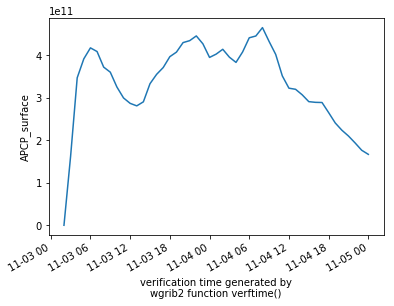

In [44]:
flux.sum(['lat', 'lon']).plot() # [kg]

In [45]:
cflux = flux.cumsum('time')

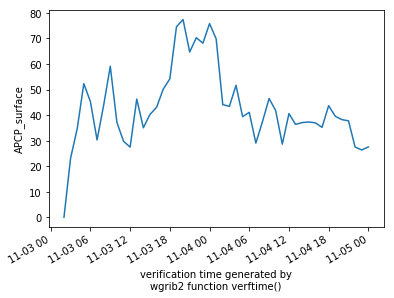

In [50]:
tpec.max(['lon', 'lat']).plot()

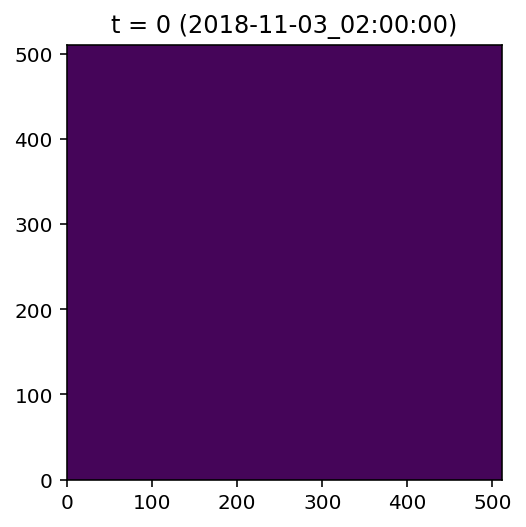

In [53]:
levels = np.arange(0, 20, 0.5) # FIXME find a better color map!
fig = plt.figure(dpi=144)
c = plt.contourf(tpec[0], levels=levels)
plt.colorbar(c)
plt.gca().set_aspect("equal")

def animate(i):
    plt.clf()
    plt.contourf(tpec[i], levels=levels)
    plt.title('t = %d (%s)' % (i, to_datetime(times[i])))
    plt.gca().set_aspect("equal")

nt = len(tpec)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=nt)
HTML(ani.to_jshtml())